In [1]:
import os
import phylustrator as ph

# We use the parsers you've already defined in your package
from phylustrator import parse_ale_file, parse_uts_file

def aggregate_ale_data(data_folder, min_freq=0.1):
    """
    Scans a folder for ALE outputs and aggregates high-confidence events.
    """
    all_transfers = []
    all_events = []
    species_tree = None
    
    if not os.path.exists(data_folder):
        print(f"Error: Path {data_folder} not found.")
        return None, [], []

    files = os.listdir(data_folder)
    print(f"Scanning {len(files)} files in {data_folder}...")

    # 1. Get Species Tree (from the first .uml_rec found)
    # We need the tree first to map node names to objects
    for f in files:
        if f.endswith(".uml_rec"):
            path = os.path.join(data_folder, f)
            ale_data = parse_ale_file(path)
            species_tree = ale_data.species_tree
            print(f"Loaded Species Tree from: {f}")
            break
            
    if not species_tree:
        raise ValueError("No .uml_rec file found. Cannot load species tree.")

    # Create a map for fast node lookup
    # ALE usually uses numeric IDs or string names in the 'name' column
    name2node = {n.name: n for n in species_tree.traverse()}

    # 2. Parse Events & Transfers
    for f in files:
        path = os.path.join(data_folder, f)
        
        # --- Transfers (.uTs) ---
        if f.endswith(".uTs") or f.endswith(".uts"):
            transfers = parse_uts_file(path)
            for tr in transfers:
                if tr['freq'] >= min_freq:
                    # Append directly; the drawer handles the mapping by name
                    all_transfers.append(tr)

        # --- Duplications & Losses (.uml_rec) ---
        elif f.endswith(".uml_rec"):
            ale_data = parse_ale_file(path)
            
            # The parser returns a DataFrame with columns: 
            # [S_node, name, Duplications, Transfers, Losses, Originations, copies]
            for _, row in ale_data.branch_stats.iterrows():
                node_name = str(row['name'])
                
                # Filter D events
                if row['Duplications'] >= min_freq:
                    if node_name in name2node:
                        all_events.append({
                            'type': 'D',
                            'node': name2node[node_name],
                            'freq': row['Duplications']
                        })
                
                # Filter L events
                if row['Losses'] >= min_freq:
                    if node_name in name2node:
                        all_events.append({
                            'type': 'L',
                            'node': name2node[node_name],
                            'freq': row['Losses']
                        })

    print(f"Aggregated {len(all_transfers)} transfers and {len(all_events)} D/L events.")
    return species_tree, all_transfers, all_events

Scanning 213 files in ../examples/data/ale...
Loaded Species Tree from: 106_prunedtree.nwk.ale.uml_rec
Aggregated 252 transfers and 237 D/L events.
Saved PNG to ale_aggregated_plot.png (Scale: 4x)


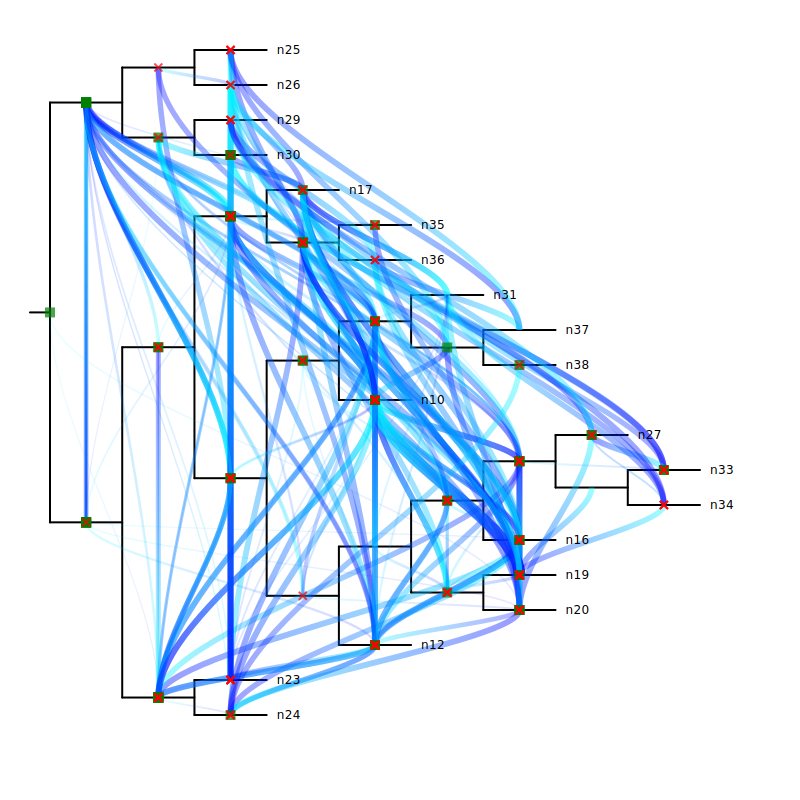

In [3]:
# 1. Load Data
# Point this to your actual folder
data_path = "../examples/data/ale"

# Set a threshold to avoid cluttering the plot with very rare events
t, transfers, events = aggregate_ale_data(data_path, min_freq=0.2)

# 2. Initialize Drawer
# Since ALE trees are usually undated cladograms, we use a standard linear style
style = ph.TreeStyle(
    width=800, 
    height=800,
    branch_color="black",
    branch_size=2,
    leaf_size=0,
    node_size=0 
)

v_drawer = ph.VerticalTreeDrawer(t, style=style)
v_drawer.draw()

# 3. Add Transfers
# Since ALE is undated, 'time' is None, so curves will use branch midpoints
v_drawer.add_transfer_links(
    transfers,
    gradient_colors=("cyan", "blue"),
    arrows=False,
    vary_width=True,    # Thicker lines = Higher frequency/confidence
    stroke_width=6,
    opacity_scale=0.4,  # Semi-transparent to handle overlaps
    curve_factor=0.3
)

# 4. Add Events
# Duplications (Green Squares)
v_drawer.mark_events(
    events, 
    type_filter="D", 
    shape="square", 
    color="green", 
    size=5, 
    opacity=0.7
)

# Losses (Red Crosses)
v_drawer.mark_events(
    events, 
    type_filter="L", 
    shape="x", 
    color="red", 
    size=4, 
    opacity=0.7
)

# 5. Finalize
v_drawer.add_leaf_names()
v_drawer.save_figure("ale_aggregated_plot.png", scale=4)
v_drawer.d

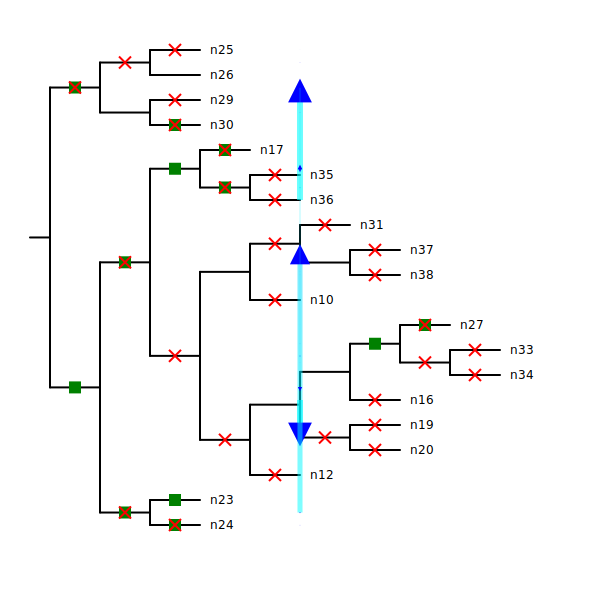

In [5]:
import phylustrator as ph
from phylustrator import parse_ale_file, parse_uts_file

# --- CONFIGURATION ---
FAMILY_NAME = "14_prunedtree.nwk.ale"  # <--- REPLACE THIS with a real name from the list above
min_freq = 0.01          # Lower threshold for single families to see everything
# ---------------------

# 1. Define Paths
rec_file = os.path.join(data_path, f"{FAMILY_NAME}.uml_rec")
uts_file = os.path.join(data_path, f"{FAMILY_NAME}.uTs") # Note: Check if extension is .uTs or .uts

if not os.path.exists(rec_file):
    raise FileNotFoundError(f"Could not find {rec_file}")

# 2. Parse ALE Data
# The .uml_rec file contains the species tree used for this specific reconciliation
ale_data = parse_ale_file(rec_file)
t = ale_data.species_tree
name2node = {n.name: n for n in t.traverse()}

# 3. Extract Events (Duplications & Losses)
# We look at the 'branch_stats' DataFrame from the parser
events = []
for _, row in ale_data.branch_stats.iterrows():
    node_name = str(row['name'])
    
    # Duplications
    if row['Duplications'] >= min_freq and node_name in name2node:
        events.append({
            'type': 'D',
            'node': name2node[node_name],
            'time': None # Use midpoint
        })
        
    # Losses
    if row['Losses'] >= min_freq and node_name in name2node:
        events.append({
            'type': 'L',
            'node': name2node[node_name],
            'time': None 
        })

# 4. Extract Transfers
transfers = []
if os.path.exists(uts_file):
    raw_transfers = parse_uts_file(uts_file)
    for tr in raw_transfers:
        if tr['freq'] >= min_freq:
            transfers.append({
                'from': tr['from'],
                'to': tr['to'],
                'freq': tr['freq'],
                'time': None # Use midpoint curve
            })
else:
    print("Warning: No .uTs file found. Skipping transfers.")

# 5. Draw
style = ph.TreeStyle(
    width=600, height=600,
    branch_size=2, leaf_size=0, node_size=0
)

v_drawer = ph.VerticalTreeDrawer(t, style=style)
v_drawer.draw()

# Add Transfers
v_drawer.add_transfer_links(
    transfers,
    gradient_colors=("cyan", "blue"),
    arrows=True,
    vary_width=True,
    stroke_width=6,
    opacity_scale=0.6,
    curve_factor=0.2
)

# Add Events
v_drawer.mark_events(events, type_filter="D", shape="square", color="green", size=6)
v_drawer.mark_events(events, type_filter="L", shape="x", color="red", size=6)

v_drawer.add_leaf_names()
v_drawer.d